In [ ]:
!pip install konlpy

In [ ]:
import numpy as np      
import pandas as pd       
import matplotlib.pyplot as plt   
import seaborn as sns

import re
from konlpy.tag import Okt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Concatenate, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import Input, Model, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

In [ ]:
train = pd.read_csv(path+'news_train.csv')
test = pd.read_csv(path + 'news_test.csv')
submission = pd.read_csv(path + 'sample_submission.csv')

In [ ]:
train.head()

,n_id,date,title,content,ord,info
0,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,[이데일리 MARKETPOINT]15:32 현재 코스닥 기관 678억 순매도,1,0
1,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,"""실적기반"" 저가에 매집해야 할 8월 급등유망주 TOP 5 전격공개",2,1
2,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,"하이스탁론, 선취수수료 없는 월 0.4% 최저금리 상품 출시",3,1
3,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,종합 경제정보 미디어 이데일리 - 무단전재 & 재배포 금지,4,0
4,NEWS09727,20200626,"롯데·공영 등 7개 TV 홈쇼핑들, 동행세일 동참",전국적인 소비 붐 조성에 기여할 예정,1,0


진짜 뉴스 개수 : 71813
가짜 뉴스 개수 : 46932
진짜 뉴스 비율 : 60.477%
가짜 뉴스 비율 : 39.523%


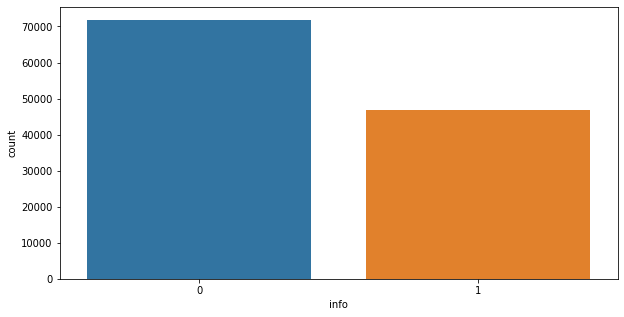

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(data=train, x="info")

print("진짜 뉴스 개수 : {}".format(len(train.loc[train['info']==0])))
print("가짜 뉴스 개수 : {}".format(len(train.loc[train['info']==1])))
print("진짜 뉴스 비율 : {}%".format(round((len(train.loc[train['info']==0])) / len(train.index) * 100, 3)))
print("가짜 뉴스 비율 : {}%".format(round((len(train.loc[train['info']==1])) / len(train.index) * 100, 3)))

In [ ]:
train['content'] = train['content'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test['content'] = test['content'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

In [ ]:
print('전처리 후 train 샘플의 개수 :',len(train))
print('전처리 후 test 샘플의 개수 :',len(test))

전처리 후 train 샘플의 개수 : 118745
전처리 후 test 샘플의 개수 : 142565


In [ ]:
stop_words = []  

with open(path + 'stopwords.txt', 'r', encoding = 'utf-8') as f:
    lines = f.readlines()
    for line in lines:
        stop_words.append(line.rstrip('\n'))

In [ ]:
okt = Okt()

X_train = []
for sentence in train['content']:
    X = []
    X = okt.morphs(sentence, stem=True) 
    X = [word for word in X if not word in stop_words] 
    X_train.append(X)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 29185


In [ ]:
X_train = tokenizer.texts_to_sequences(X_train)
y_train = np.array(train['info'])

리뷰의 최대 길이 : 901
리뷰의 평균 길이 : 14.477257989810097


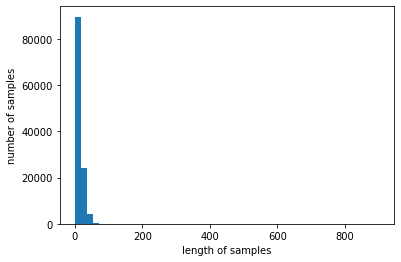

In [ ]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [ ]:
max_len = 45
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 45 이하인 샘플의 비율: 98.59699355762348


In [ ]:
X_train = pad_sequences(X_train, maxlen = max_len, padding = 'post')
y_train = to_categorical(y_train)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [ ]:
print(X_train.shape)
print(X_val.shape)

print(y_train.shape)
print(y_val.shape)

(83121, 45)
(35624, 45)
(83121, 2)
(35624, 2)


## BiLSTM with Attention Mechanism 모델링

<img src = "https://wikidocs.net/images/page/22893/dotproductattention4_final.PNG">


In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = Dense(units)
    self.W2 = Dense(units)
    self.V = Dense(1)

  def call(self, values, query): # 단, key와 value는 같음
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    # score(query, key) = vT * tanh(W1 * key + W2 * query)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
sequence_input = Input(shape=(max_len,), dtype='float32')
embedded_sequences = Embedding(vocab_size, 128, input_length=max_len, mask_zero = True)(sequence_input)

In [ ]:
lstm, forward_h, forward_c, backward_h, backward_c = Bidirectional \
    (LSTM
     (64,
      dropout=0.3,
      return_sequences=True,
      return_state=True,
      recurrent_activation='relu',
      recurrent_initializer='glorot_uniform'))(embedded_sequences)

In [ ]:
print(lstm.shape, forward_h.shape, forward_c.shape, backward_h.shape, backward_c.shape)

(None, 45, 128) (None, 64) (None, 64) (None, 64) (None, 64)


In [ ]:
state_h = Concatenate()([forward_h, backward_h]) 
state_c = Concatenate()([forward_c, backward_c]) 

attention = BahdanauAttention(64) 
context_vector, attention_weights = attention(lstm, state_h)
hidden = BatchNormalization()(context_vector)

dense1 = Dense(20, activation="relu")(context_vector)
dropout = Dropout(0.5)(dense1)
output = Dense(2, activation="sigmoid")(dropout)
model = Model(inputs=sequence_input, outputs=output)

es = EarlyStopping(monitor='val_loss', mode='min', patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accurary', mode='max', save_best_only=True)
Adam = optimizers.Adam(lr=0.0001, clipnorm=1.)
model.compile(optimizer=Adam, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 45, 128)      3735680     input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 45, 128), (N 98816       embedding_1[0][0]                
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 128)          0           bidirectional_1[0][1]            
                                                                 bidirectional_1[0][3]      

In [ ]:
history = model.fit(X_train, y_train, epochs = 50, batch_size = 256, validation_data=(X_val, y_val),  callbacks = [es, mc], verbose=1)

Epoch 1/50
325/325 [==============================] - 96s 278ms/step - loss: 0.6900 - accuracy: 0.6010 - val_loss: 0.6901 - val_accuracy: 0.6070


Epoch 2/50
325/325 [==============================] - 89s 274ms/step - loss: 0.6894 - accuracy: 0.6032 - val_loss: 0.6871 - val_accuracy: 0.6070


Epoch 3/50
325/325 [==============================] - 88s 272ms/step - loss: 0.6867 - accuracy: 0.6030 - val_loss: 0.6846 - val_accuracy: 0.6070


Epoch 4/50
325/325 [==============================] - 89s 273ms/step - loss: 0.6844 - accuracy: 0.6032 - val_loss: 0.6824 - val_accuracy: 0.6070


Epoch 5/50
325/325 [==============================] - 90s 278ms/step - loss: 0.6824 - accuracy: 0.6022 - val_loss: 0.6804 - val_accuracy: 0.6070


Epoch 6/50
325/325 [==============================] - 89s 274ms/step - loss: 0.6803 - accuracy: 0.6048 - val_loss: 0.6787 - val_accuracy: 0.6070


Epoch 7/50
325/325 [==============================] - 89s 274ms/step - loss: 0.6787 - accuracy: 0.6047 - val_loss: 0.6772 - val_accuracy: 0.6070


Epoch 8/50
325/325 [==============================] - 88s 272ms/step - loss: 0.6773 - accuracy: 0.6047 - val_loss: 0.6759 - val_accuracy: 0.6070


Epoch 9/50
325/325 [==============================] - 88s 272ms/step - loss: 0.6761 - accuracy: 0.6048 - val_loss: 0.6748 - val_accuracy: 0.6070


Epoch 10/50
325/325 [==============================] - 88s 270ms/step - loss: 0.6751 - accuracy: 0.6046 - val_loss: 0.6739 - val_accuracy: 0.6070


Epoch 11/50
325/325 [==============================] - 89s 275ms/step - loss: 0.6748 - accuracy: 0.6025 - val_loss: 0.6731 - val_accuracy: 0.6070


Epoch 12/50
325/325 [==============================] - 91s 281ms/step - loss: 0.6741 - accuracy: 0.6028 - val_loss: 0.6724 - val_accuracy: 0.6070


Epoch 13/50
325/325 [==============================] - 91s 281ms/step - loss: 0.6730 - accuracy: 0.6045 - val_loss: 0.6719 - val_accuracy: 0.6070


Epoch 14/50
325/325 [==============================] - 91s 279ms/step - loss: 0.6725 - accuracy: 0.6047 - val_loss: 0.6714 - val_accuracy: 0.6070


Epoch 15/50
325/325 [==============================] - 91s 280ms/step - loss: 0.6718 - accuracy: 0.6057 - val_loss: 0.6711 - val_accuracy: 0.6070


Epoch 16/50
325/325 [==============================] - 92s 282ms/step - loss: 0.6710 - accuracy: 0.6070 - val_loss: 0.6709 - val_accuracy: 0.6070


Epoch 17/50
325/325 [==============================] - 90s 276ms/step - loss: 0.6727 - accuracy: 0.6017 - val_loss: 0.6706 - val_accuracy: 0.6070


Epoch 18/50
325/325 [==============================] - 88s 271ms/step - loss: 0.6710 - accuracy: 0.6058 - val_loss: 0.6705 - val_accuracy: 0.6070


Epoch 19/50
325/325 [==============================] - 90s 275ms/step - loss: 0.6708 - accuracy: 0.6062 - val_loss: 0.6704 - val_accuracy: 0.6070


Epoch 20/50
325/325 [==============================] - 91s 280ms/step - loss: 0.6712 - accuracy: 0.6047 - val_loss: 0.6703 - val_accuracy: 0.6070


Epoch 21/50
325/325 [==============================] - 89s 273ms/step - loss: 0.6718 - accuracy: 0.6032 - val_loss: 0.6702 - val_accuracy: 0.6070


Epoch 22/50
325/325 [==============================] - 88s 270ms/step - loss: 0.6722 - accuracy: 0.6021 - val_loss: 0.6702 - val_accuracy: 0.6070


Epoch 23/50
325/325 [==============================] - 87s 267ms/step - loss: 0.6713 - accuracy: 0.6043 - val_loss: 0.6702 - val_accuracy: 0.6070


Epoch 24/50
325/325 [==============================] - 87s 267ms/step - loss: 0.6710 - accuracy: 0.6051 - val_loss: 0.6702 - val_accuracy: 0.6070


Epoch 25/50
325/325 [==============================] - 89s 274ms/step - loss: 0.6715 - accuracy: 0.6036 - val_loss: 0.6702 - val_accuracy: 0.6070


Epoch 26/50
325/325 [==============================] - 88s 271ms/step - loss: 0.6719 - accuracy: 0.6028 - val_loss: 0.6701 - val_accuracy: 0.6070


Epoch 27/50
325/325 [==============================] - 91s 280ms/step - loss: 0.6709 - accuracy: 0.6050 - val_loss: 0.6701 - val_accuracy: 0.6070


Epoch 28/50
325/325 [==============================] - 90s 277ms/step - loss: 0.6719 - accuracy: 0.6026 - val_loss: 0.6701 - val_accuracy: 0.6070


Epoch 29/50
325/325 [==============================] - 89s 274ms/step - loss: 0.6714 - accuracy: 0.6038 - val_loss: 0.6701 - val_accuracy: 0.6070


Epoch 30/50
325/325 [==============================] - 87s 267ms/step - loss: 0.6726 - accuracy: 0.6010 - val_loss: 0.6701 - val_accuracy: 0.6070


Epoch 31/50
325/325 [==============================] - 88s 269ms/step - loss: 0.6702 - accuracy: 0.6066 - val_loss: 0.6701 - val_accuracy: 0.6070


Epoch 32/50
325/325 [==============================] - 89s 275ms/step - loss: 0.6717 - accuracy: 0.6033 - val_loss: 0.6701 - val_accuracy: 0.6070


Epoch 33/50
325/325 [==============================] - 92s 282ms/step - loss: 0.6724 - accuracy: 0.6016 - val_loss: 0.6701 - val_accuracy: 0.6070


Epoch 34/50
325/325 [==============================] - 88s 271ms/step - loss: 0.6714 - accuracy: 0.6039 - val_loss: 0.6701 - val_accuracy: 0.6070


Epoch 35/50
325/325 [==============================] - 88s 272ms/step - loss: 0.6707 - accuracy: 0.6056 - val_loss: 0.6701 - val_accuracy: 0.6070


Epoch 36/50
325/325 [==============================] - 89s 273ms/step - loss: 0.6720 - accuracy: 0.6025 - val_loss: 0.6701 - val_accuracy: 0.6070


Epoch 37/50
325/325 [==============================] - 89s 273ms/step - loss: 0.6720 - accuracy: 0.6026 - val_loss: 0.6701 - val_accuracy: 0.6070


Epoch 38/50
325/325 [==============================] - 89s 275ms/step - loss: 0.6716 - accuracy: 0.6034 - val_loss: 0.6701 - val_accuracy: 0.6070


Epoch 39/50
325/325 [==============================] - 89s 275ms/step - loss: 0.6719 - accuracy: 0.6027 - val_loss: 0.6701 - val_accuracy: 0.6070


Epoch 40/50
325/325 [==============================] - 88s 272ms/step - loss: 0.6703 - accuracy: 0.6065 - val_loss: 0.6701 - val_accuracy: 0.6070


Epoch 41/50
325/325 [==============================] - 88s 270ms/step - loss: 0.6717 - accuracy: 0.6032 - val_loss: 0.6701 - val_accuracy: 0.6070


Epoch 42/50
325/325 [==============================] - 88s 270ms/step - loss: 0.6712 - accuracy: 0.6044 - val_loss: 0.6701 - val_accuracy: 0.6070


Epoch 43/50
325/325 [==============================] - 89s 275ms/step - loss: 0.6715 - accuracy: 0.6037 - val_loss: 0.6701 - val_accuracy: 0.6070


Epoch 44/50
325/325 [==============================] - 91s 280ms/step - loss: 0.6709 - accuracy: 0.6051 - val_loss: 0.6701 - val_accuracy: 0.6070


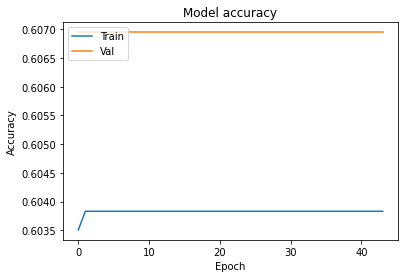

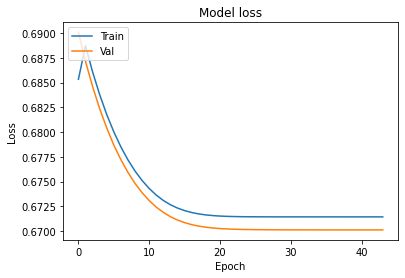

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
print('Loss: %f' % (loss))
print('Accuracy: %f' % (accuracy*100))

Loss: 0.670115
Accuracy: 60.695034
